In [22]:
import bs4
from bs4 import BeautifulSoup as bs
import pandas as pd
import scipy as sc
import numpy as np
import requests as req
from selenium import webdriver
PATH = 'C:\Program Files (x86)\chromedriver.exe'
from selenium.webdriver.common.keys import Keys
import time
import matplotlib as mpl
import matplotlib.pyplot as plt      
import math
from collections import Counter
from sklearn import linear_model, metrics, preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler ,LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, f1_score
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from plotly.subplots import make_subplots
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline

steam_pages = 100
metacritic_pages = 125 #from 125

In [ ]:
count=0
h = "https://store.steampowered.com/search/?category1=998&os=win&filter=topsellers"
prices = list()

# selenium - scrolling down on steam:
driver=webdriver.Chrome(PATH)
driver.get(h)
html = driver.find_element_by_tag_name('html')
time.sleep(1)   
previous_height = driver.execute_script('return document.body.scrollHeight;')
for x in range (1,steam_pages):
# while True:
    driver.execute_script('window.scrollTo(0,document.body.scrollHeight);')
    time.sleep(1)
    new_height = driver.execute_script('return document.body.scrollHeight;')
    if new_height == previous_height:
        break
    previous_height = new_height
html_final=html.get_attribute('innerHTML')

In [ ]:
def load_soup_object(html_doc):
    soup = bs(html_doc,"html.parser")
    return soup

# crawling:
soup = load_soup_object(html_final)
inner_soup = soup.find( id ='search_resultsRows' )

game_title = soup.findAll('span' , attrs={'class':'title'})
game_release_date = soup.findAll('div' , attrs={'class':'col search_released responsive_secondrow'})
game_price = soup.findAll( 'div' , attrs = {'class':'search_price'})
game_review = soup.findAll( 'div' , attrs = {'class':'col search_reviewscore responsive_secondrow'})
Win_platform = soup.findAll( 'span' , attrs = {'class':'platform_img win'})

#get inner games links:
inner_games_list = list() 
for link in inner_soup.find_all('a'):
    inner_games_list.append(link.get('href'))


In [14]:
#get inner game html:
game_html = list()
game_developers = list()
game_details = list()
game_metascore = list()
game_storage = list()
labels = list()
clean_game_developers = list()
clean_game_details = list()
clean_game_metascore = list()
clean_game_storage = list()


i=0
for game in inner_games_list:
    game_html.append(req.get(game))
    game_soup = bs(game_html[i].text,"html.parser")
    game_developers.append(game_soup.find( id='developers_list' ))
    game_metascore.append(game_soup.find( id='game_area_metascore' ))
    game_storage.append(game_soup.findAll('div', attrs={'class':'game_area_sys_req'}))
    game_details.append(game_soup.find(id = 'genresAndManufacturer'))
    labels.append(game_soup.findAll('div' , attrs={'class':'label'}))
    i+=1
    
#cleaning developers:
i=0
str_dev_list = [str(i) for i in game_developers]

for dev in game_developers:
    clean_dev = bs(str_dev_list[i] , "lxml").text
    clean_game_developers.append(clean_dev.strip())
    i+=1

#getting details with junk:
i=0
str_pub_list = [str(i) for i in game_details]

for pub in game_details:
    clean_details = bs(str_pub_list[i] , "lxml").text
    clean_game_details.append(clean_details.strip())
    i+=1

#getting metascore:
i=0
str_metascore = [str(i) for i in game_metascore]

for pub in game_metascore:
    clean_metascore = bs(str_metascore[i] , "lxml").text
    clean_game_metascore.append(clean_metascore.strip())
    i+=1    

#getting storage:
i=0
str_storage = [str(i) for i in game_storage]

for pub in game_storage:
    clean_storage = bs(str_storage[i] , "lxml").text
    clean_game_storage.append(clean_storage.strip())
    i+=1


In [15]:
#find lables:

onlineCoop = list()
lanCoop=list()
singlePlayer=list()
onlinePVP=list()
fullControlerSupport=list()
patrialControllerSupport=list()
inAppPurch=list()
MMO=list()
SSCPVP=list()
j=0
for l in labels:
    str_storage = [str(i) for i in labels]
    r1 = str_storage[j].find('Online Co-op')
    r2 = str_storage[j].find('LAN Co-op')
    r3 = str_storage[j].find('Single-player')
    r4 = str_storage[j].find('Online PvP')
    r5 = str_storage[j].find('Full controller support')
    r6 = str_storage[j].find('Partial Controller Support')
    r7 = str_storage[j].find('In-App Purchases')
    r8 = str_storage[j].find('MMO')
    r9 = str_storage[j].find('Shared/Split Screen PvP')

    if r1 >= 0:
        onlineCoop.append(1)
    else:
        onlineCoop.append(0)
    if r2 >= 0:
        lanCoop.append(1)
    else:   
        lanCoop.append(0)
    if r3 >= 0:
        singlePlayer.append(1)
    else:   
        singlePlayer.append(0)
    if r4 >= 0:
        onlinePVP.append(1)
    else:   
        onlinePVP.append(0)
    if r5 >= 0:
        fullControlerSupport.append(1)
    else:   
        fullControlerSupport.append(0)
    if r6 >=0:
        patrialControllerSupport.append(1)
    else:
        patrialControllerSupport.append(0)
    if r7 >=0:
        inAppPurch.append(1)
    else:
        inAppPurch.append(0)
    if r8 >=0:
        MMO.append(1)
    else:
        MMO.append(0)
    if r9 >=0:
        SSCPVP.append(1)
    else:
        SSCPVP.append(0)
    
    j+=1


In [22]:
#creating the df:
df=pd.DataFrame({'GameTitles':game_title , 'ReleaseYear':game_release_date , 'Price':game_price ,'Developer':clean_game_developers,
                 'Publisher':clean_game_details , 'Genre':clean_game_details,'Franchise': clean_game_details,
                 'Storage(GB)':clean_game_storage , 'SinglePlayer':singlePlayer,'onlineCo-op':onlineCoop,
                 'lanCo-op':lanCoop,'onlinePVP':onlinePVP,'FullControllerSupport':fullControlerSupport,'partialControllerSupport':patrialControllerSupport,
                 'inAppPurchases':inAppPurch,'MMO':MMO,'sharedSplitScreenPVP':SSCPVP,
                'SteamPositivePrecent':game_review , 'SteamUserReviews':game_review ,'Metascore':clean_game_metascore })
df.index+=1

# df.to_csv('rowDF.csv')


In [31]:
df

,GameTitles,ReleaseYear,Price,Developer,Publisher,Genre,Franchise,Storage(GB),SinglePlayer,onlineCo-op,lanCo-op,onlinePVP,FullControllerSupport,partialControllerSupport,inAppPurchases,MMO,sharedSplitScreenPVP,SteamPositivePrecent,SteamUserReviews,Metascore
1,"<span class=""title"">Counter-Strike: Global Off...","<div class=""col search_released responsive_sec...","<div class=""col search_price responsive_second...","Valve, Hidden Path Entertainment",Title: Counter-Strike: Global Offensive\nGenre...,Title: Counter-Strike: Global Offensive\nGenre...,Title: Counter-Strike: Global Offensive\nGenre...,[\n\n\nMinimum:OS: Windows® 7/Vista/XPProcesso...,0,0,0,0,1,0,1,0,0,"<div class=""col search_reviewscore responsive_...","<div class=""col search_reviewscore responsive_...",83\t\t\t\t\t\t\t\t\t\n\n\nmetacritic\nRead Cri...
2,"<span class=""title"">Apex Legends™</span>","<div class=""col search_released responsive_sec...","<div class=""col search_price responsive_second...",Respawn Entertainment,"Title: Apex Legends™\nGenre: Action, Adventure...","Title: Apex Legends™\nGenre: Action, Adventure...","Title: Apex Legends™\nGenre: Action, Adventure...",[\n\n\nMinimum:Requires a 64-bit processor and...,0,1,0,1,1,0,1,0,0,"<div class=""col search_reviewscore responsive_...","<div class=""col search_reviewscore responsive_...",88\t\t\t\t\t\t\t\t\t\n\n\nmetacritic\nRead Cri...
3,"<span class=""title"">Tiny Tina's Wonderlands</s...","<div class=""col search_released responsive_sec...","<div class=""col search_price discounted respon...",Gearbox Software,"Title: Tiny Tina's Wonderlands\nGenre: Action,...","Title: Tiny Tina's Wonderlands\nGenre: Action,...","Title: Tiny Tina's Wonderlands\nGenre: Action,...",[\n\n\nMinimum:Requires a 64-bit processor and...,1,1,1,0,1,0,0,0,0,"<div class=""col search_reviewscore responsive_...","<div class=""col search_reviewscore responsive_...",None
4,"<span class=""title"">MONSTER HUNTER RISE</span>","<div class=""col search_released responsive_sec...","<div class=""col search_price discounted respon...","CAPCOM Co., Ltd.",Title: MONSTER HUNTER RISE\nGenre: Action\n\nD...,Title: MONSTER HUNTER RISE\nGenre: Action\n\nD...,Title: MONSTER HUNTER RISE\nGenre: Action\n\nD...,[\n\n\nMinimum:Requires a 64-bit processor and...,1,1,0,0,1,0,0,0,0,"<div class=""col search_reviewscore responsive_...","<div class=""col search_reviewscore responsive_...",87\t\t\t\t\t\t\t\t\t\n\n\nmetacritic\nRead Cri...
5,"<span class=""title"">NARAKA: BLADEPOINT</span>","<div class=""col search_released responsive_sec...","<div class=""col search_price discounted respon...",24 Entertainment,"Title: NARAKA: BLADEPOINT\nGenre: Action, Adve...","Title: NARAKA: BLADEPOINT\nGenre: Action, Adve...","Title: NARAKA: BLADEPOINT\nGenre: Action, Adve...",[\n\n\nMinimum:OS: Windows 7 64-bit or newerPr...,0,0,0,1,0,1,1,0,0,"<div class=""col search_reviewscore responsive_...","<div class=""col search_reviewscore responsive_...",71\t\t\t\t\t\t\t\t\t\n\n\nmetacritic\nRead Cri...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4946,"<span class=""title"">Madohi Shiroki no Kamikaku...","<div class=""col search_released responsive_sec...","<div class=""col search_price discounted respon...",Lump of Sugar,Title: Madohi Shiroki no Kamikakushi\nGenre: A...,Title: Madohi Shiroki no Kamikakushi\nGenre: A...,Title: Madohi Shiroki no Kamikakushi\nGenre: A...,[\n\n\nMinimum:OS: Windows Vista/７/８/10Process...,1,0,0,0,0,0,0,0,0,"<div class=""col search_reviewscore responsive_...","<div class=""col search_reviewscore responsive_...",None
4947,"<span class=""title"">Land of War - The Beginnin...","<div class=""col search_released responsive_sec...","<div class=""col search_price discounted respon...",MS GAMES,Title: Land of War - The Beginning\nGenre: Act...,Title: Land of War - The Beginning\nGenre: Act...,Title: Land of War - The Beginning\nGenre: Act...,[\n\n\nMinimum:OS: Windows 7 x64Processor: i5M...,1,0,0,0,0,1,0,0,0,"<div class=

In [30]:
df = pd.read_csv('rowDF.csv')
df = df.drop(columns=['Unnamed: 0'])
df.index+=1

#creating clean by word function:
def clean_by_word(df_column , fromWord ,toWord , addons_list):
    new_list = list ()
    clean_new_list = list()
    for index, w in enumerate(df[df_column]):
        df[df_column][index+1].strip()
        word =  df[df_column][index+1]
        result = word.find(fromWord)
        word2 =  df[df_column][index+1][result:]
        new_list.append(word2)
        result2 = word2.find(toWord)
        clean_new_list.append(new_list[index][:result2])
        df[df_column][index+1] = clean_new_list[index]

    for addon in addons_list:
        df[df_column] = df[df_column].str.replace(addon, '')


In [ ]:
# change dtype object >> str:
df['GameTitles'] = df['GameTitles'].astype(str)
df['ReleaseYear'] = df['ReleaseYear'].astype(str)
df['Price'] = df['Price'].astype(str)
df['SteamPositivePrecent'] = df['SteamPositivePrecent'].astype(str)
df['SteamUserReviews'] = df['SteamUserReviews'].astype(str)
df['Metascore'] = df['Metascore'].astype(str)


#remove useless chars:
spec_chars = ["!",'"',"#","%","&","(",")",
              "*","+",",","-","/",";","<",
              "=",">","?","@","[","\\","]","^",
              "`","{","|","}","~" ,"™" ,"®"]
rev_price_addons = ["span" , "class" , "title" , "div" , "strike" , "col" 
                ,"search_price" , "search_released", "responsive_secondrow",
                "search_reviewscore" , "search_review_summary" , "positive" ,
                "data", "tooltip" , "html" , "\\n" , "Positive" , "Very",
                "lt" , "br" ,"gt" , "Overwhelmingly" , "Mostly" , "mixed",
                "Mixed" , "of" , "discounted" , "style" , "or" , "888888" ,"user reviews f this game are",
                "This product has experienced" , ". one  me periods  ftopic review activity.",
                 "Based on your ", "preferences the review" , "s within these periods" ,
                 "    have been excluded" , "  from this products " , "Review Sce" , '< ="platfm_img win"></>'] 

html_addons = ["span" , "class" , "title" , "div" , "strike" , "col" 
                ,"search_price" , "search_released", "responsive_secondrow","omig",
                "search_reviewscore" , "search_review_summary" ,
                "data" , "\t\t\t\t\t\t\t\t\t\n\n\nmetacritic\nRead" , "Critic Reviews","NA\n\nmetacritic\nNot yet reviewed.","Soon","e 16","ment","ouce"] 

more_addons = ["Publisher:" , "\\n" , "Genre:" , "Franchise:" , "Storage:" ,", Free to Play" , "Free to Play," ,", Early Access",'Atleast']

pos_rev_addons = ["\\n" ,'<div class="col search_reviewscore responsive' ,'_secondrow"><span class="search_review_summary',
                    ' positive" data-tooltip-html="Very Positive&lt;br&gt;' , ' user reviews for this game are positive."></span></div>',
                    'positive" data-tooltip-html="Overwhelmingly','Positive&lt;br&gt;','mixed" data-tooltip-html="Mixed&lt;br&gt;', 'Storage',':',' ','fthe',".",
                    'positive" data-tooltip-html="Mostly ', ' user reviews for this game ','are positive.&lt;br&gt;&lt;br&gt;This product has experienced one or more periods of off-topic review activity.',
                    '  Based on your preferences, the reviews within these periods have been excluded from this product\'s Review Score."></span></div>','"',
                    ' user reviews for this software are positive.','></span></div>' ,'of the ' ,',' ,'_secondrow"></div>', "_secondrow></div>"," or " ,"+" ,"m"," user reviews for gaes in this bundle are positive.", "></span></div>",
                    "userreviewsforthisgaearepositive",".&lt;br&gt;&lt;br&gt;Thisproducthasexperiencedoneororeperiodsofoff-topicreviewactivity.Basedonyourpreferencesthereviewswithintheseperiodshavebeenexcludedfrothisp",
                    "roduct'sReviewScore.","&lt;br&gt;&lt;br&gt;Thisproducthasexperiencedoneororeperiodsofoff-topicreviewactivityBasedonyourpreferencesthereviewswithintheseperiodshavebeenexcludedfrothispro",
                    "duct'sReviewScore" ,"userreviewsforthissoftwarearepositive" ,'userreviewsforgaesinthisbundlearepositive','Atleast',
                    'Mindestens','userreviewsforthisvideoarepositive']      

for char in spec_chars:
    df['GameTitles'] = df['GameTitles'].str.replace(char, '')
    df['ReleaseYear'] = df['ReleaseYear'].str.replace(char, '')
    df['Price'] = df['Price'].str.replace(char, '')
    df['SteamPositivePrecent'] = df['SteamPositivePrecent'].str.replace(char, '')    

for addon in html_addons:
    df['GameTitles'] = df['GameTitles'].str.replace(addon, '')
    df['ReleaseYear'] = df['ReleaseYear'].str.replace(addon, '')
    df['Metascore'] = df['Metascore'].str.replace(addon, '')

for addon in rev_price_addons:
    df['Price'] = df['Price'].str.replace(addon, '')
    df['SteamPositivePrecent'] = df['SteamPositivePrecent'].str.replace(addon, '')

for posrev in pos_rev_addons:
    df['SteamUserReviews'] = df['SteamUserReviews'].str.replace(posrev, '')

#striping and cleaning columns:
for i in range(1,len(game_title)+1):
    df['GameTitles'][i] = df['GameTitles'][i].strip()
    df['ReleaseYear'][i] = df['ReleaseYear'][i].strip()
    df['Price'][i] = df['Price'][i].strip()
    df['SteamPositivePrecent'][i] = df['SteamPositivePrecent'][i].strip()

#creating nums list of int >> str
rate_list = list()
for i in range (0,101):
    rate_list.append(i)   

str_rate_list = [str(i) for i in rate_list]

#cleaning reviews:
i=1
for x in df['SteamPositivePrecent']:
    df['SteamPositivePrecent'][i]=x[:4].strip()
    if df['SteamPositivePrecent'][i] not in str_rate_list:
        df['SteamPositivePrecent'][i]='-1'
    i+=1
df['SteamPositivePrecent'] = df['SteamPositivePrecent'].astype(int)

#cleaning from details by word:
clean_by_word('Publisher' , 'Publisher:' , '\n\n', more_addons)
clean_by_word('Genre' , 'Genre:' ,'\n\n', more_addons)
clean_by_word('Franchise' , 'Franchise:' ,'\n\n', more_addons)       

#removing GB/MB:

new_list = list ()
clean_new_list = list()

for index, w in enumerate(df['Storage(GB)']):
    df['Storage(GB)'][index+1].strip()
    word =  df['Storage(GB)'][index+1]
    result = word.find('Storage:')
    word2 =  df['Storage(GB)'][index+1][result+8:]
    new_list.append(word2)
    result2 = word2.find('B')
    clean_new_list.append(new_list[index][:result2+1])
    if (result >= 0):
        df['Storage(GB)'][index+1] = clean_new_list[index]
    if (word2 == 0 or result == -1):
        df['Storage(GB)'][index+1] = 0

#cleaning Storage(GB):
Storage_addons = ['At least','Mindestens', '+','-','/',']','NaN','nan',
'[',':','*',' ','.384\t\t\t\t\t1.384']

for addon in Storage_addons:
    df['Storage(GB)'] = df['Storage(GB)'].str.replace(addon, '')


df['Storage(GB)'] = df['Storage(GB)'].astype(str)

# converting Storage(GB) to numbers:

for index, s in enumerate(df['Storage(GB)']):
    df['Storage(GB)'][index+1].strip()
    word =  df['Storage(GB)'][index+1]
    result = word.find('MB')
    if result >= 0:
        df['Storage(GB)'][index+1]=df['Storage(GB)'][index+1][:-2].strip()
    else:
        df['Storage(GB)'][index+1]=df['Storage(GB)'][index+1][:-2]
        df['Storage(GB)'][index+1]=df['Storage(GB)'][index+1]+"000"

    if (df['Storage(GB)'][index+1] == 'n000'):
        df['Storage(GB)'][index+1] = 0

df['Storage(GB)'] = df['Storage(GB)'].astype(float)

for index, s in enumerate(df['Storage(GB)']):
    df['Storage(GB)'][index+1]=df['Storage(GB)'][index+1]/1000


In [ ]:
#clean ReleaseYear:

for index,x in enumerate(df['ReleaseYear']):
    counter = len(x)
    df['ReleaseYear'][index+1] = df['ReleaseYear'][index+1][counter-4:].strip()
    if df['ReleaseYear'][index+1] == '':
        df['ReleaseYear'][index+1] = 0
    try:
        n = int(df['ReleaseYear'][index+1])
    except:
        df['ReleaseYear'][index+1] = 0

df['ReleaseYear'] = df['ReleaseYear'].astype(int)

In [ ]:
#cleaning Genre:
new_list = list ()
for index, w in enumerate(df['Genre']):
    df['Genre'][index+1].strip()
    word =  df['Genre'][index+1]
    result = word.find(',')
    if result == -1:
         df['Genre'][index+1] = word
         continue
    if result >= 0:
        word2 =  df['Genre'][index+1][:result]
        df['Genre'][index+1] = word2       

In [26]:
#cleaning Price:
new_list = list ()
for index, w in enumerate(df['Price']):
    df['Price'][index+1].strip()
    word =  df['Price'][index+1]
    result = word.find('₪')
    result3 = word.find('Free')
    if word == '':
        new_list.append('0')
        continue
    if result3 > -1:
         new_list.append('0')
         continue
    if result >= 0:
        word2 =  df['Price'][index+1][result:]
        result2 = word2[1:].find('₪')
        if result2 > -1:
            new_list.append(word2[1:result2+1])
        else:
            new_list.append(word2[1:])

for new_price in new_list:
    df['Price'] = new_list

df['Price'] = df['Price'].astype(float)


In [ ]:
#cleaning PositiveReviews:
for index, r in enumerate(df['SteamUserReviews']):
    df['SteamUserReviews'][index+1].strip()
    word =  df['SteamUserReviews'][index+1]
    result = word.find('%')
    if result >= 0:
        df['SteamUserReviews'][index+1]=df['SteamUserReviews'][index+1][result+2:].strip()
    if r == '':
        df['SteamUserReviews'][index+1] = '0'
df['SteamUserReviews'] = df['SteamUserReviews'].astype(int)

# df.to_csv('cleanDF.csv')
df = pd.read_csv('cleanDF.csv')

In [33]:
df = pd.read_csv('cleanDF.csv')
df = df.drop(columns=['Unnamed: 0'])
df.index+=1
df

,GameTitles,ReleaseYear,Price,Developer,Publisher,Genre,Franchise,Storage(GB),SinglePlayer,onlineCo-op,lanCo-op,onlinePVP,FullControllerSupport,partialControllerSupport,inAppPurchases,MMO,sharedSplitScreenPVP,SteamPositivePrecent,SteamUserReviews,Metascore
1,CounterStrike: Global Offensive,2012,0.00,"Valve, Hidden Path Entertainment",Valve,Action,NaN,15.0,0,0,0,0,1,0,1,0,0,88,6470443,83
2,Apex Legends,2020,0.00,Respawn Entertainment,Electronic Arts,Action,Apex Legends,56.0,0,1,0,1,1,0,1,0,0,86,470815,88
3,Tiny Tina's Wonderlands,2022,239.00,Gearbox Software,2K,Action,Tiny Tina's Wonderlands,75.0,1,1,1,0,1,0,0,0,0,75,300,None
4,MONSTER HUNTER RISE,2022,239.00,"CAPCOM Co., Ltd.","CAPCOM Co., Ltd.",Action,Monster Hunter,36.0,1,1,0,0,1,0,0,0,0,87,22016,87
5,NARAKA: BLADEPOINT,2021,109.95,24 Entertainment,NetEase Games Montréal,Action,NaN,20.0,0,0,0,1,0,1,1,0,0,79,95057,71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4946,Madohi Shiroki no Kamikakushi,2022,110.95,Lump of Sugar,HIKARI FIELD,Adventure,NaN,4.0,1,0,0,0,0,0,0,0,0,95,132,None
4947,Land of War The Beginning,2021,73.95,MS GAMES,MS GAMES sp. z o.o.,Action,NaN,25.0,1,0,0,0,0,1,0,0,0,53,449,None
4948,Bonfire Peaks,2021,73.95,Corey Martin,Draknek,Indie,Draknek & Friends,0.5,1,0,0,0,1,0,0,0,0,98,117,81
4949,Long Gone Days,2018,55.95,BURA,BURA,Indie,NaN,2.0,1,0,0,0,1,0,0,0,0,94,236,None


In [ ]:
h2 = 'https://www.metacritic.com/browse/games/release-date/available/pc/userscore'
i=0

driver=webdriver.Chrome(PATH)
driver.get(h2)
html = driver.find_element_by_tag_name('html')
html_final=html.get_attribute('innerHTML')

#metacritic crawling - getting list of urls:
soup = load_soup_object(html_final)


#getting pages links:
pages_links = soup.findAll('a' , attrs={'class':'page_num'})
pages_links_list = [str(i) for i in pages_links]

final_pages_list = list()
pages_link = pages_links_list[1][26:81]
for x in range (0,125):
    final_pages_list.append("https://www.metacritic.com"+pages_link+str(x))

cleaner_metaC_games = list()
cleaner_metaC_reviews = list()
cleaner_metaC_metascore = list()
metaC_rating_list = list()

#getting titles and ratings:
for x in range(0,metacritic_pages):
    # driver=webdriver.Chrome(PATH)
    driver.get('chrome://settings/clearBrowserData')
    driver.find_element_by_xpath('//settings-ui').send_keys(Keys.ENTER)
    driver.get(final_pages_list[x])
    html = driver.find_element_by_tag_name('html')
    html_final=html.get_attribute('innerHTML')
    soup = load_soup_object(html_final)

    metaC_game_title = soup.findAll('a' , attrs={'class':'title'})
    metaC_users_rating = soup.findAll('div' , attrs={'class':'clamp-score-wrap'})
    metaC_rating = soup.select('div.metascore_w.large.game')

    #cleaning titles:
    str_metaC_game_list = [str(i) for i in metaC_game_title]
    str_metaC_users_rating = [str(i) for i in metaC_users_rating]
    str_metaC_rating = [str(i) for i in metaC_rating]


    i=0
    for g in metaC_game_title:
        clean_metaC_game = bs(str_metaC_game_list[i] , "lxml").text
        cleaner_metaC_games.append(clean_metaC_game.strip())
        i+=1

    i=0
    for g in metaC_users_rating:
        clean_metaC_game = bs(str_metaC_users_rating[i] , "lxml").text
        cleaner_metaC_reviews.append(clean_metaC_game.strip())
        i+=1

    for p,w in enumerate(str_metaC_rating):
        result = str_metaC_rating[p].find('user')
        if (result > 0):
            continue
        else:
            metaC_rating_list.append(str_metaC_rating[p])

    
#creating the new df:
meta_df=pd.DataFrame({'GameTitles':cleaner_metaC_games , 'metaUsersScore':cleaner_metaC_reviews , 'meta_metaScore': metaC_rating_list})
meta_df.index+=1
meta_df['metaUsersScore'] = meta_df['metaUsersScore'].astype(float)

#clean meta_metaScore:
div_addons = ['<div class="metascore_w large game ','positive">','</div>','tbd">','mixed">','negative">']

for addon in div_addons:
    meta_df['meta_metaScore'] = meta_df['meta_metaScore'].str.replace(addon, '')

new_list = list ()
for index, w in enumerate(meta_df['meta_metaScore']):
    meta_df['meta_metaScore'][index+1].strip()
    word =  meta_df['meta_metaScore'][index+1]
    result = word.find('tbd')
    if result >= 0:
        meta_df['meta_metaScore'][index+1] = 0

meta_df['meta_metaScore'] = meta_df['meta_metaScore'].astype(int)

# meta_df.to_csv('rowMETADF.csv')


In [24]:
#importing relevant dataframes:
meta_df = pd.read_csv('rowMETADF.csv')
meta_df = meta_df.drop(columns=['Unnamed: 0'])
meta_df.index+=1

df = pd.read_csv('cleanDF.csv')
df = df.drop(columns=['Unnamed: 0'])
df.index+=1

#Merging dataframes: 
meta_df['GameTitles'] = meta_df['GameTitles'].str.upper()
df_copy = df.copy(deep=True)
df_copy['GameTitles'] = df_copy['GameTitles'].str.upper()
df_copy = df_copy.merge(meta_df , how='left' , on='GameTitles')
df_copy.index+=1
for index, w in enumerate(df_copy['meta_metaScore']):
    if math.isnan(df_copy['meta_metaScore'][index+1]):
        df_copy['meta_metaScore'][index+1] = 0 

df_copy['meta_metaScore'] = df_copy['meta_metaScore'].astype(int)

for x, w in enumerate(df_copy['Metascore']):
    if(df_copy['meta_metaScore'][x+1]!= 0 and df_copy['Metascore'][x+1] == 'Noe') or ((df_copy['meta_metaScore'][x+1]!= 0 and df_copy['Metascore'][x+1] == 'None')):
        df_copy['Metascore'][x+1] = df_copy['meta_metaScore'][x+1]


C:\Users\liors\AppData\Local\Temp\ipykernel_25248\202482440.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['meta_metaScore'][index+1] = 0
C:\Users\liors\AppData\Local\Temp\ipykernel_25248\202482440.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['Metascore'][x+1] = df_copy['meta_metaScore'][x+1]


In [25]:
#creating the num of labels column:

df_copy['numOfLabels'] = 0

count =0
for x,v in enumerate(df_copy['SinglePlayer']):
    count = df_copy['SinglePlayer'][x+1] + df_copy['onlineCo-op'][x+1] + df_copy['lanCo-op'][x+1] + df_copy['onlinePVP'][x+1] + df_copy['FullControllerSupport'] + df_copy['partialControllerSupport'][x+1] + df_copy['inAppPurchases'][x+1] + df_copy['MMO'][x+1] + df_copy['sharedSplitScreenPVP'][x+1]
    df_copy['numOfLabels'][x+1] = count.values[0]
    count = 0


C:\Users\liors\AppData\Local\Temp\ipykernel_25248\2289615502.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['numOfLabels'][x+1] = count.values[0]


In [26]:

#creating a df copy and removing NaN:
df_copy = df_copy[df_copy['metaUsersScore'].notna()]
df_copy = df_copy[df_copy['Metascore'].notna()]
df_copy = df_copy[df_copy.Metascore != 'None']
df_copy = df_copy[df_copy.Metascore != 'Noe']
df_copy = df_copy[df_copy.Metascore != '']
df_copy = df_copy[df_copy['Storage(GB)'] != 0]
df_copy = df_copy[df_copy['ReleaseYear'] >= 1900]
df_copy = df_copy[df_copy['Storage(GB)'] <= 1000]
df_copy = df_copy.drop_duplicates(subset='GameTitles')
df_copy = df_copy.reset_index()
df_copy = df_copy.drop(columns=['index','meta_metaScore'])
df_copy.index+=1


In [27]:
df_copy['Metascore'] = df_copy['Metascore'].astype(int)
df_copy['Genre'] = df_copy['Genre'].astype(str)

for index,w in enumerate(df_copy['Genre']):
    df_copy['Genre'][index+1]=df_copy['Genre'][index+1].strip()

#df_copy.to_csv('mergedDF.csv')
df_copy.info()

C:\Users\liors\AppData\Local\Temp\ipykernel_25248\1540602455.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['Genre'][index+1]=df_copy['Genre'][index+1].strip()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1343 entries, 1 to 1343
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   GameTitles                1343 non-null   object 
 1   ReleaseYear               1343 non-null   int64  
 2   Price                     1343 non-null   float64
 3   Developer                 1343 non-null   object 
 4   Publisher                 1343 non-null   object 
 5   Genre                     1343 non-null   object 
 6   Franchise                 802 non-null    object 
 7   Storage(GB)               1343 non-null   float64
 8   SinglePlayer              1343 non-null   int64  
 9   onlineCo-op               1343 non-null   int64  
 10  lanCo-op                  1343 non-null   int64  
 11  onlinePVP                 1343 non-null   int64  
 12  FullControllerSupport     1343 non-null   int64  
 13  partialControllerSupport  1343 non-null   int64  
 14  inAppPur

In [3]:
#importimg the merged df:

df_copy = pd.read_csv('mergedDF.csv')
df_copy = df_copy.drop(columns=['Unnamed: 0'])
df_copy.index+=1

,ReleaseYear,Price,Storage(GB),SinglePlayer,onlineCo-op,lanCo-op,onlinePVP,FullControllerSupport,partialControllerSupport,inAppPurchases,MMO,sharedSplitScreenPVP,SteamPositivePrecent,SteamUserReviews,Metascore,metaUsersScore,numOfLabels
ReleaseYear,1.000000,0.286204,0.136943,-0.025624,0.077418,-0.016458,0.030640,0.123956,-0.049592,-0.028465,-0.076935,0.013510,-0.090185,-0.167278,-0.063565,-0.187084,0.002650
Price,0.286204,1.000000,0.499307,0.090206,0.191864,0.088434,0.198679,0.061186,0.034830,0.040156,-0.112185,0.053974,-0.218157,-0.032892,0.045595,-0.149587,0.203756
Storage(GB),0.136943,0.499307,1.000000,-0.170495,0.283022,0.083392,0.344493,0.044965,0.072698,0.340789,0.166310,0.020381,-0.276812,0.213345,0.018863,-0.260469,0.363550
SinglePlayer,-0.025624,0.090206,-0.170495,1.000000,-0.224706,-0.006173,-0.247117,0.093780,-0.076957,-0.420835,-0.413931,0.036661,0.081657,-0.271301,-0.006533,0.085497,-0.173831
onlineCo-op,0.077418,0.191864,0.283022,-0.224706,1.000000,0.280943,0.447163,-0.032627,0.017980,0.232734,0.154590,0.087044,-0.168910,0.174932,-0.015888,-0.171757,0.665990
lanCo-op,-0.016458,0.088434,0.083392,-0.006173,0.280943,1.000000,0.159938,-0.063171,-0.008596,-0.007695,-0.017773,-0.011452,0.010211,0.108943,0.097836,0.034382,0.290535
onlinePVP,0.030640,0.198679,0.344493,-0.247117,0.447163,0.159938,1.000000,-0.058672,0.058276,0.339459,0.184016,0.326275,-0.187150,0.138398,0.012881,-0.161343,0.760758
FullControllerSupport,0.123956,0.061186,0.044965,0.093780,-0.032627,-0.063171,-0.058672,1.000000,-0.539689,-0.059480,-0.124741,0.097586,0.024438,-0.004800,0.019875,-0.028914,-0.234968
partialControllerSupport,-0.049592,0.034830,0.072698,-0.076957,0.017980,-0.008596,0.058276,-0.539689,1.000000,0.095338,0.044674,-0.013192,-0.033564,0.028301,-0.094601,-0.040926,0.414591
inAppPurchases,-0.028465,0.040156,0.340789,-0.420835,0.232734,-0.007695,0.339459,-0.059480,0.095338,1.000000,0.430851,0.094871,-0.154471,0.293646,-0.021088,-0.246630,0.505422


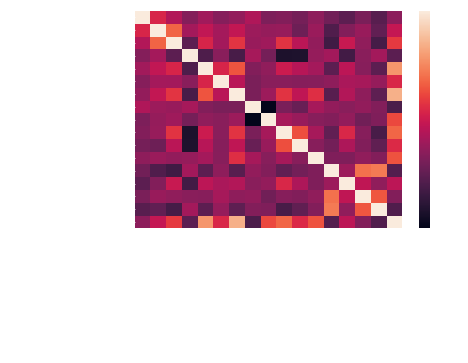

In [28]:
cor = df_copy.corr(method ='pearson')
ax = sns.heatmap(cor,color='w')
cor


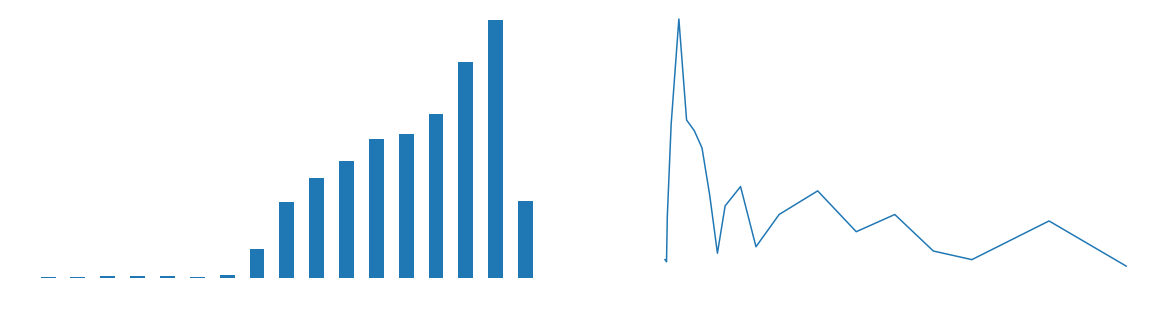

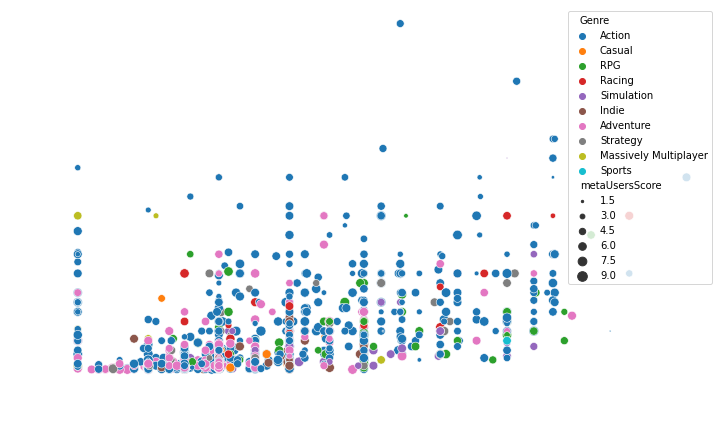

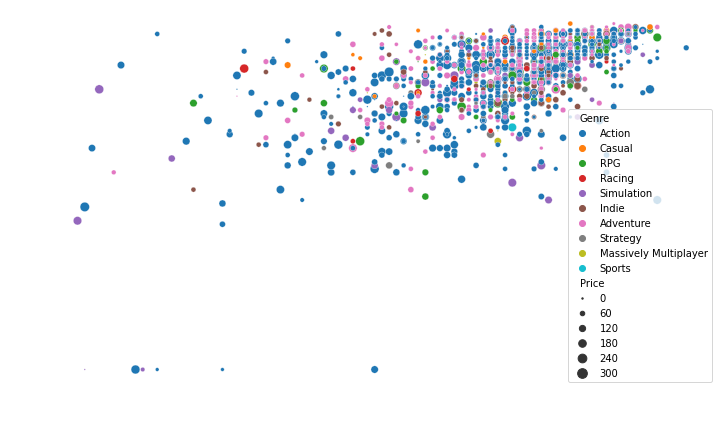

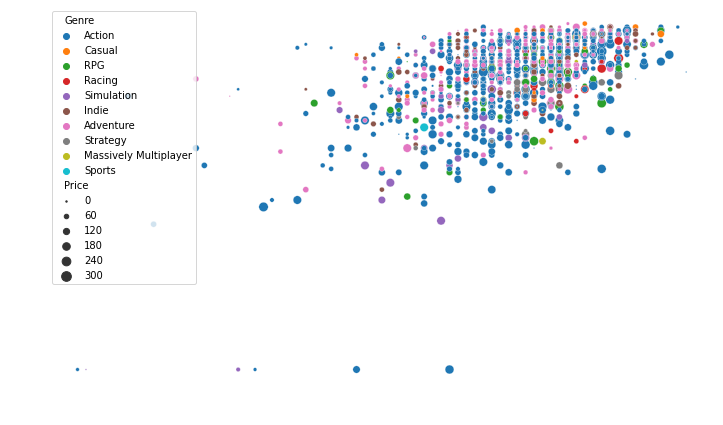

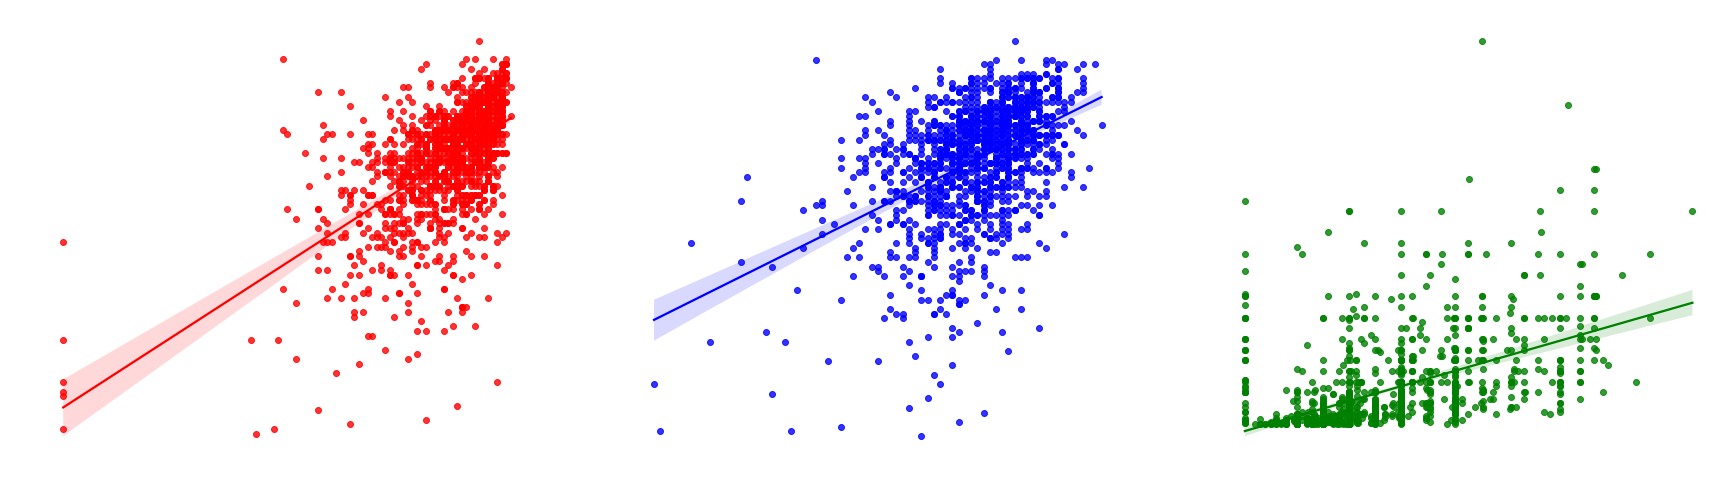

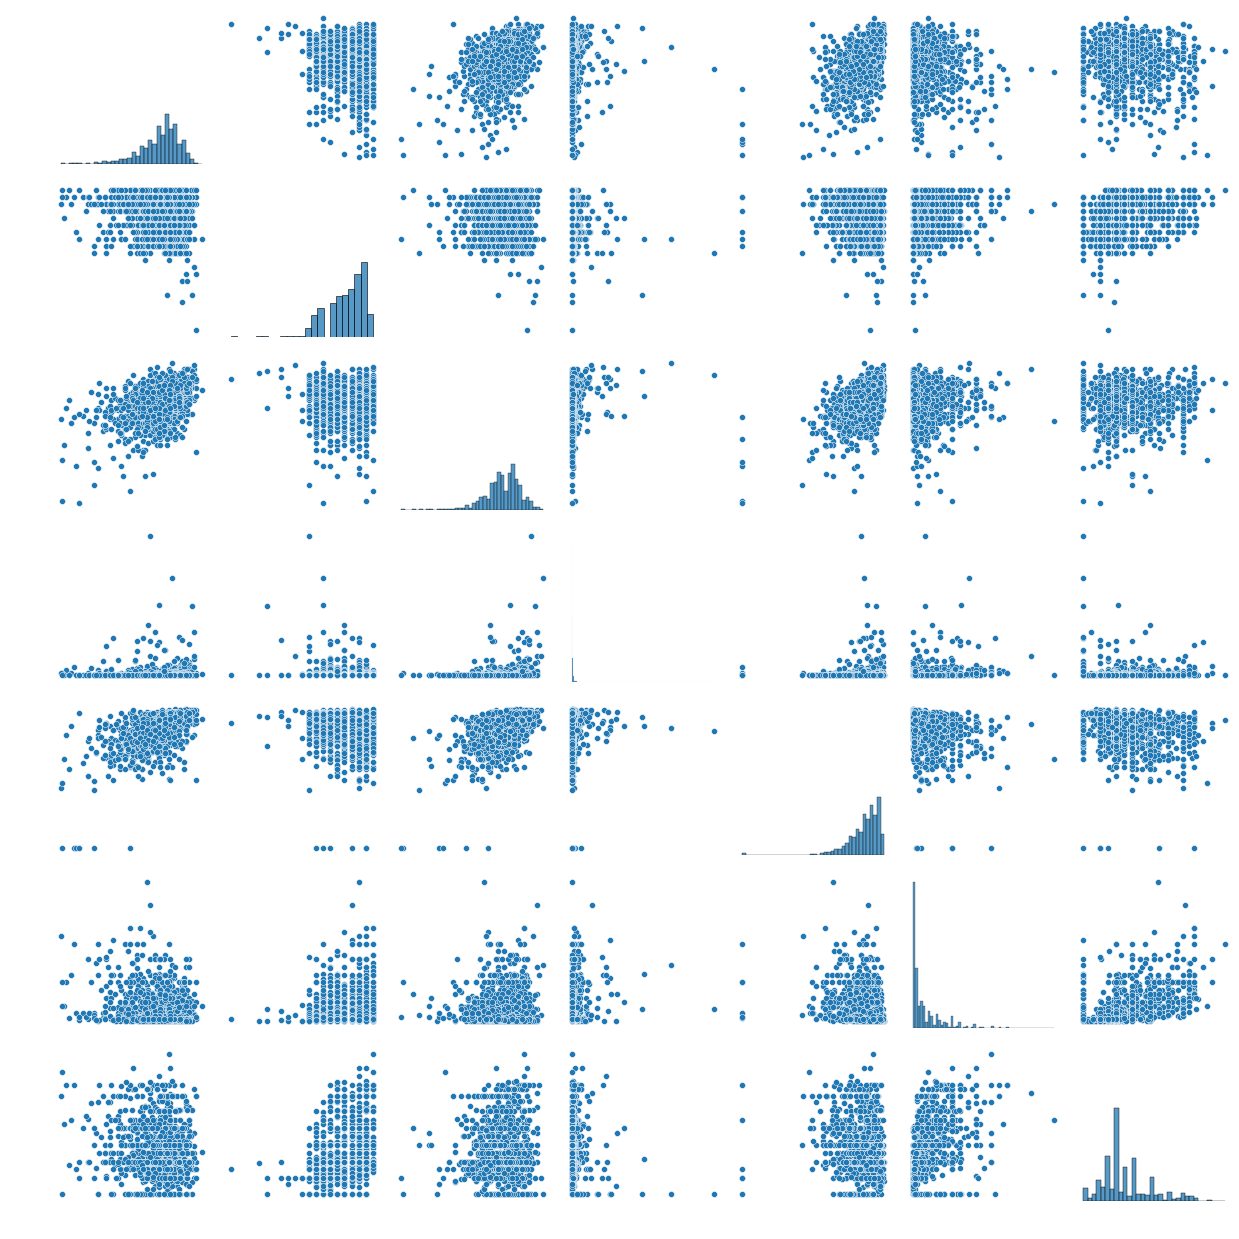

In [16]:
# plt functions:

def one_dim_plot(sr, plot_type, axis):
    sr.plot(kind=plot_type , ax=axis)

def get_frequent_elements(df, col_name, num_top_elements):
    topele = df[col_name].value_counts()[:num_top_elements]
    topele = topele.sort_index()
    return topele

def plot_frequent_elements(df, df_in_params):
    fig, axes = plt.subplots(1,df_in_params.shape[0], figsize=(20,5))
    for i in range(df_params.shape[0]):
        x=get_frequent_elements(df,df_params['col_name'][i],df_params['num_top_elements'][i])
        one_dim_plot(x,df_params['plot_type'][i],axes[i])

def cross_tabulation(df, col_name, other_col_name):
    ct1 = pd.crosstab(df[col_name],df[other_col_name],normalize='index')
    return ct1

def plot_cross_tabulation(df, col_names, other_col_name):
    i=0
    fig, axes = plt.subplots(1,2, figsize=(20,5))
    for val in col_names:
        new_df= cross_tabulation(df,val,other_col_name)
        new_df.plot(ax=axes[i])
        i=i+1

#---------------------------

params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}

plt.rcParams.update(params)

# bar and line plots:
df_params = pd.DataFrame({'plot_type': ['bar', 'line'], 
                          'col_name': ['ReleaseYear', 'Storage(GB)'],'num_top_elements': [30,60]})
plot_frequent_elements(df_copy, df_params)

#colorful dots plot:
fig = plt.figure(figsize=(12,7))
sns.scatterplot(x='Price' , y='Storage(GB)' , size='metaUsersScore' , hue='Genre',sizes=(2,100) ,data=df_copy)

fig = plt.figure(figsize=(12,7))
sns.scatterplot(x='metaUsersScore' , y='SteamPositivePrecent' , size='Price' , hue='Genre',sizes=(2,100) ,data=df_copy)

fig = plt.figure(figsize=(12,7))
sns.scatterplot(x='Metascore' , y='SteamPositivePrecent' , size='Price' , hue='Genre',sizes=(2,100) ,data=df_copy)

#nice new scatter plt
fig, axs = plt.subplots(ncols=3, figsize=(30,8))
sns.regplot(x="SteamPositivePrecent", y="metaUsersScore", data=df_copy, ax=axs[0], color='r')
sns.regplot(x="Metascore", y="metaUsersScore", data=df_copy, ax=axs[1], color='b')
sns.regplot(x="Price", y="Storage(GB)", data=df_copy, ax=axs[2], color='g')
axs[0].set_title('Steam Positive Precent and metascores Users Score (Top platforms)', fontsize=10, color='w')
axs[1].set_title('Critic Metascore and Metascores Users Score', fontsize=10, color='w')
axs[2].set_title('Price and Storage in (GB)', fontsize=10, color='w')
plt.show()

#pariplot:
sns.pairplot(df_copy[['metaUsersScore','ReleaseYear','Metascore','SteamUserReviews','SteamPositivePrecent','Storage(GB)','Price']])



<AxesSubplot:ylabel='Genre'>

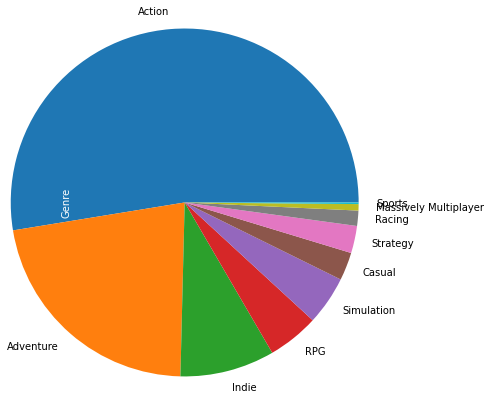

In [17]:
Genre_counts = df_copy['Genre'].value_counts()
Genre_counts.plot(kind='pie' , radius = 2)



<AxesSubplot:ylabel='numOfLabels'>

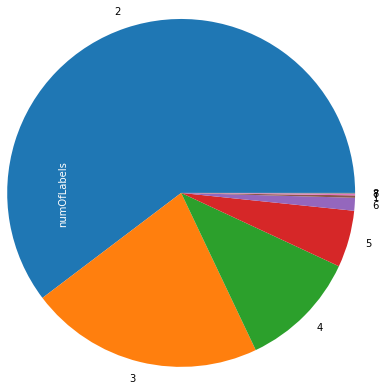

In [18]:
numOfLabels_count = df_copy['numOfLabels'].value_counts()
numOfLabels_count.plot(kind='pie' , radius = 2)

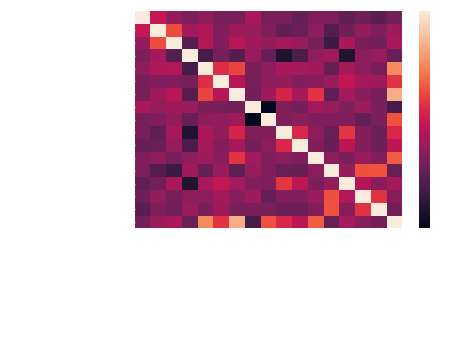

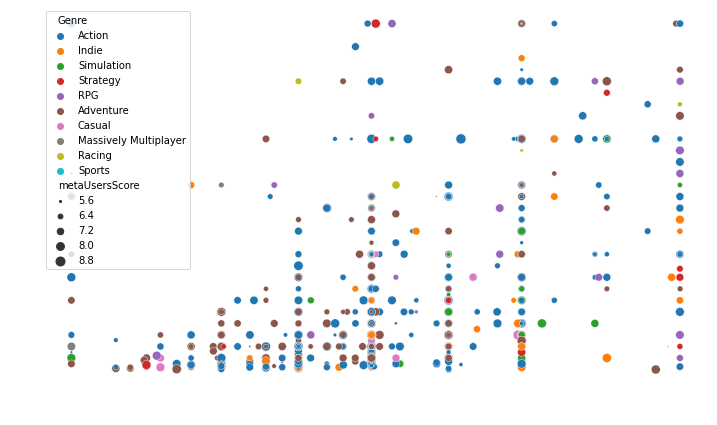

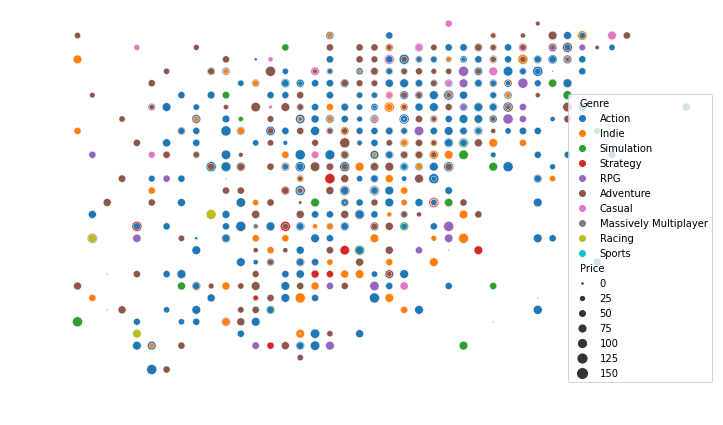

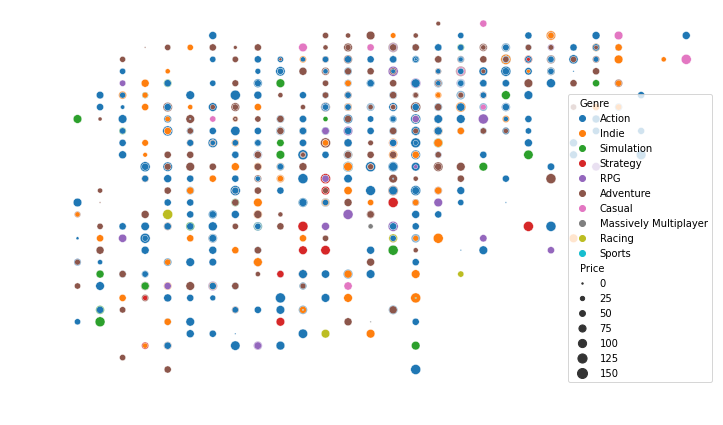

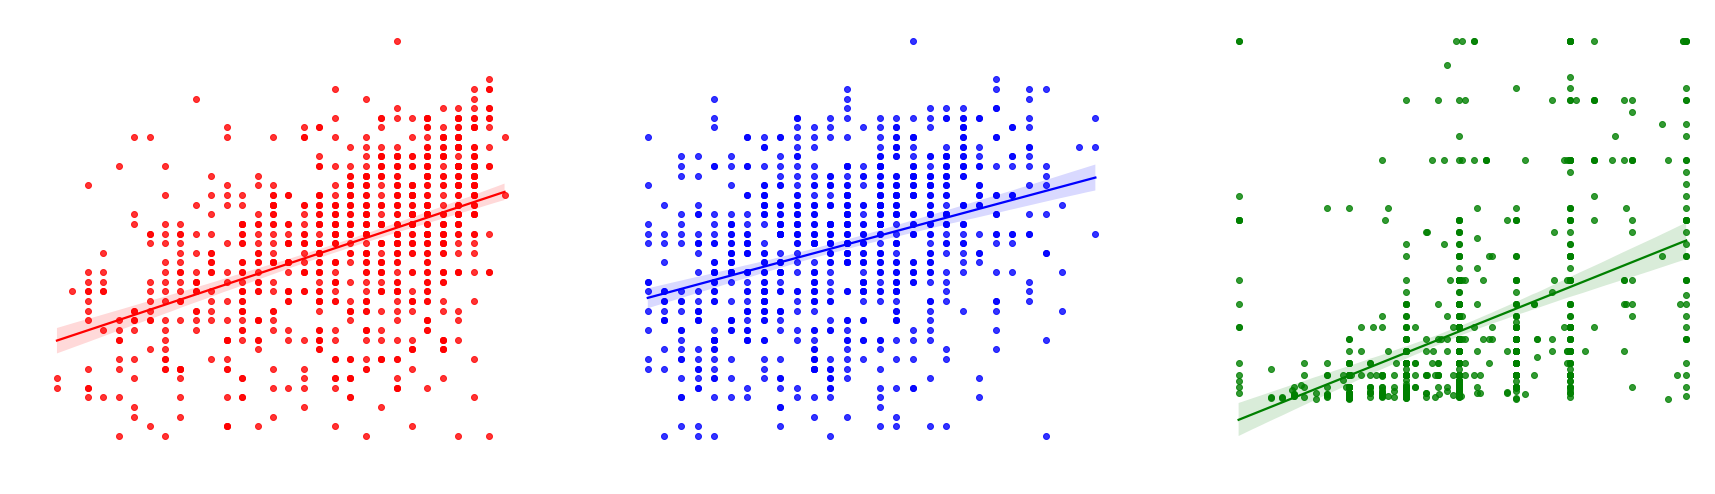

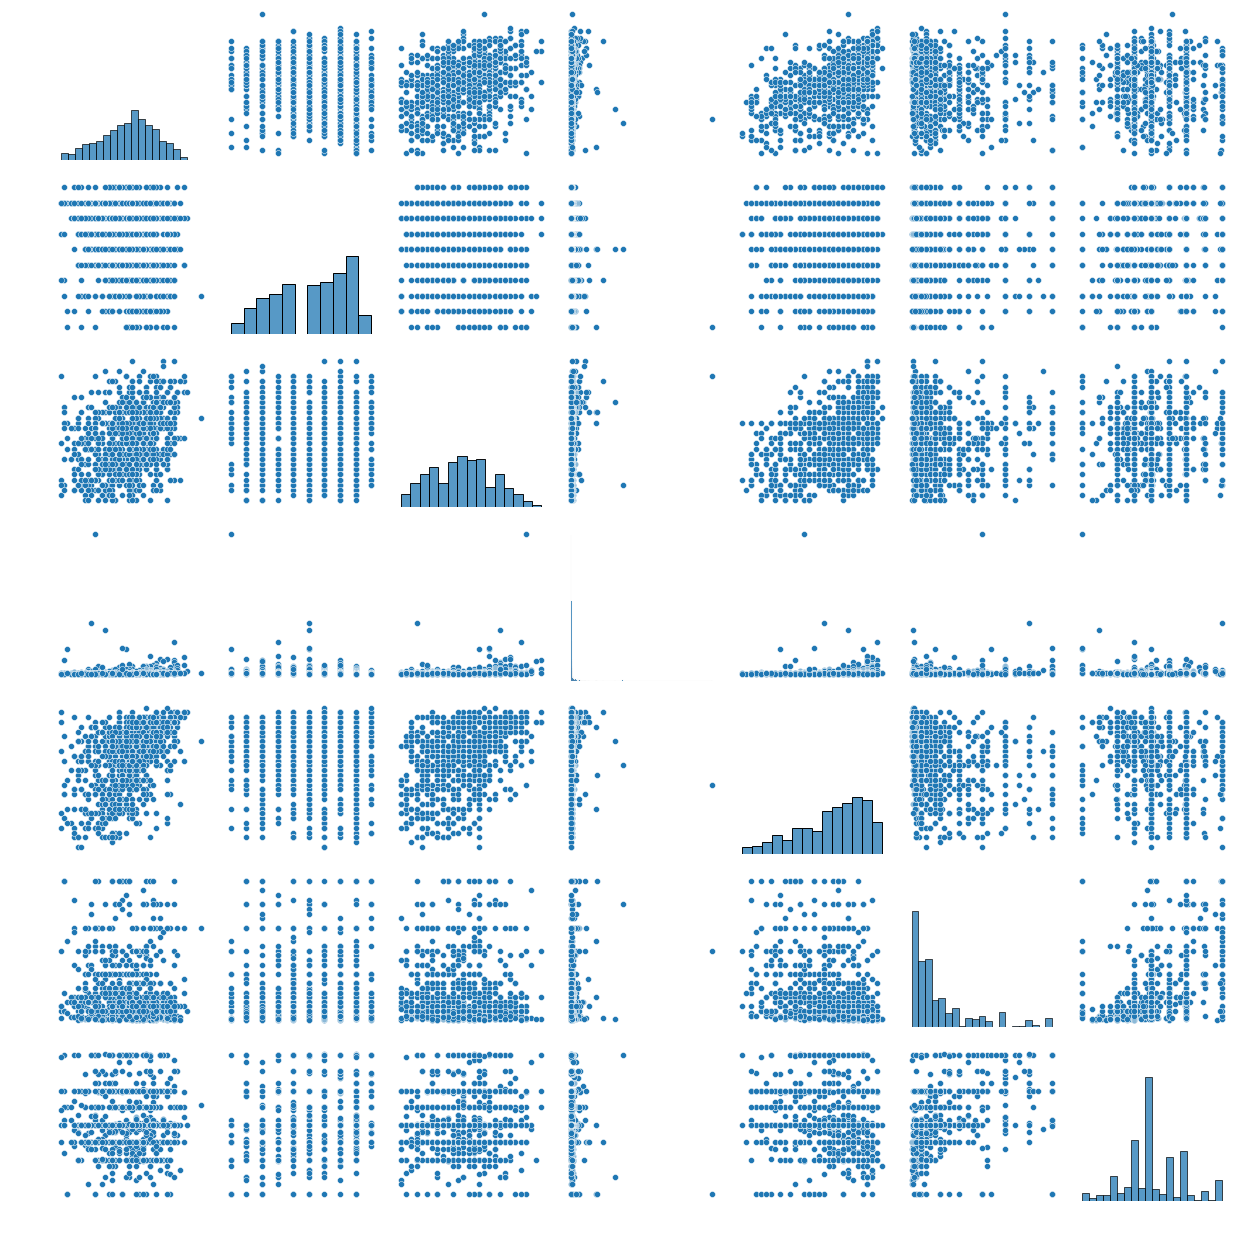

In [ ]:
#EDA:
df_copy = df_copy[df_copy['SteamPositivePrecent'] >= 70]
df_copy = df_copy[df_copy['metaUsersScore'] >= 5.5]
df_copy = df_copy[df_copy['Metascore'] > 65]
df_copy = df_copy[df_copy['Price'] <= 150]
df_copy = df_copy[df_copy['Storage(GB)'] <= 30]
df_copy = df_copy[df_copy['ReleaseYear'] > 2012]

params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}

plt.rcParams.update(params)

# # bar and line plots:
# df_params = pd.DataFrame({'plot_type': ['bar', 'line'], 
#                           'col_name': ['ReleaseYear', 'Storage(GB)'],'num_top_elements': [30,60]})
# plot_frequent_elements(df_copy, df_params)

#colorful dots plot:
fig = plt.figure(figsize=(12,7))
sns.scatterplot(x='Price' , y='Storage(GB)' , size='metaUsersScore' , hue='Genre',sizes=(2,100) ,data=df_copy)

fig = plt.figure(figsize=(12,7))
sns.scatterplot(x='metaUsersScore' , y='SteamPositivePrecent' , size='Price' , hue='Genre',sizes=(2,100) ,data=df_copy)

fig = plt.figure(figsize=(12,7))
sns.scatterplot(x='Metascore' , y='SteamPositivePrecent' , size='Price' , hue='Genre',sizes=(2,100) ,data=df_copy)

#nice new scatter plt
fig, axs = plt.subplots(ncols=3, figsize=(30,8))
sns.regplot(x="SteamPositivePrecent", y="metaUsersScore", data=df_copy, ax=axs[0], color='r')
sns.regplot(x="Metascore", y="metaUsersScore", data=df_copy, ax=axs[1], color='b')
sns.regplot(x="Price", y="Storage(GB)", data=df_copy, ax=axs[2], color='g')
axs[0].set_title('Steam Positive Precent and metascores Users Score (Top platforms)', fontsize=10, color='w')
axs[1].set_title('Critic Metascore and Metascores Users Score', fontsize=10, color='w')
axs[2].set_title('Price and Storage in (GB)', fontsize=10, color='w')
plt.show()

#pariplot:
sns.pairplot(df_copy[['metaUsersScore','ReleaseYear','Metascore','SteamUserReviews','SteamPositivePrecent','Storage(GB)','Price']])


Coefficients: [-6.65167797e-02  1.90636026e-05 -3.00118473e-03 -4.49773954e-03
 -1.93563470e-01  2.12766710e-02  3.55766824e-01  1.57290157e-01
 -1.53485431e-01  8.82889524e-02 -4.98234208e-01 -3.88083354e-01
  2.84553032e-01  3.96673395e-02 -6.05689576e-08  3.51212333e-02
 -1.72705396e-01]
Intercept: 136.07481999458017
Mean squered error (MSE): 0.77
Coefficient of determination (R^2): 0.58 / 1.0
True Score: 0.5840100189446336


c:\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


0.5840100189446336

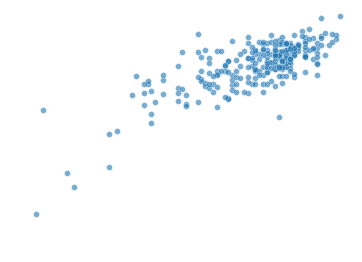

In [ ]:
final_df = df_copy.copy(deep=True)
final_df = final_df.drop(columns=['GameTitles','Publisher','Developer','Franchise'])
le=LabelEncoder()
final_df['Genre'] = le.fit_transform(final_df['Genre'])
#----------------------------------
#normalizinig the new df:
normalized_df=(final_df-final_df.mean())/final_df.std()

#fixing the final score:
#final_df['metaUsersScore_Metascore_ratio']=final_df['numOfLabels']/final_df['SteamUserReviews']

#creating the prediction:
x_df = final_df.drop(columns=['metaUsersScore'])
y_df = final_df['metaUsersScore']

l = LinearRegression()
x_train , x_test , y_train , y_test = train_test_split(x_df,y_df, test_size=0.2 , random_state = 6160)
l.fit(x_train,y_train)
pred = l.predict(x_test)

print('Coefficients:',l.coef_)
print('Intercept:',l.intercept_)
print('Mean squered error (MSE): %.2f' % mean_squared_error(y_test , pred))
print('Coefficient of determination (R^2): %.2f' % r2_score(y_test, pred),'/ 1.0')
print('True Score:',l.score(x_test,y_test))
#final plot:
sns.scatterplot(y_test,pred,alpha=0.6)

l.score(x_test,y_test)
